# Projet de réassurance

## Step 1 Code initialisation

### Import the datasets into dataframes with pandas

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting

MTPL_filepath1 = "C:/Users/grego/Documents/USPN M2/REASSURANCE/Projet/freMTPLfreq.xlsx"
MTPL_filepath2 = "C:/Users/grego/Documents/USPN M2/REASSURANCE/Projet/freMTPLsev.xlsx"

print("Now loading MTPLfreq.")
MTPLfreq = pd.read_excel(MTPL_filepath1)
print("MTPLfreq was loaded./n")

print("Now loading MTPLsev.")
MTPLsev = pd.read_excel(MTPL_filepath2)
print("MTPLsev was loaded./n")

Now loading MTPLfreq.
MTPLfreq was loaded./n
Now loading MTPLsev.
MTPLsev was loaded./n


### Perform a merge to join them together

In [2]:

# Check for total amount of claims paid in original DataFrame, prior to merging MTPLfreq with MTPLsev.
print(sum(MTPLsev['ClaimAmount']))

# Aggregate the claim amounts by PolicyID, prior to merging MTPLfreq with MTPLsev.
MTPLsev_grp = MTPLsev.groupby(['PolicyID'])[['ClaimAmount']].agg('sum').reset_index()

# Perform an outer merge between MTPLfreq/MTPLsev, based on PolicyID, then reset the index back to PolicyID (this is dropped during merging).
df_merged = pd.merge(MTPLfreq, MTPLsev_grp, how='outer', on='PolicyID').fillna(0).set_index('PolicyID')

# Check for the total amount of claims paid in new DataFrame, after merging MTPLfreq with MTPLsev.
print(sum(df_merged['ClaimAmount']))


print(df_merged.columns)
print('\n')
print(df_merged.dtypes)
print('\n')
print(df_merged.head())
print('\n')

34465077
34465077.0
Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'prime', 'ClaimAmount'],
      dtype='object')


ClaimNb          int64
Exposure       float64
Power           object
CarAge           int64
DriverAge        int64
Brand           object
Gas             object
Region          object
Density          int64
prime          float64
ClaimAmount    float64
dtype: object


          ClaimNb  Exposure Power  CarAge  DriverAge  \
PolicyID                                               
1               0      0.09     g       0         46   
2               0      0.84     g       0         46   
3               0      0.52     f       2         38   
4               0      0.45     f       2         38   
5               0      0.15     g       0         41   

                                       Brand      Gas              Region  \
PolicyID                                                                    
1        

## Step 2: Review and understand the meaning of the data (columns), then assign the features/targets to their own dataframes

### Understanding the columns and their datatypes


In [3]:
print(df_merged.columns)
print('\n')
print(df_merged.dtypes)
print('\n')

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'prime', 'ClaimAmount'],
      dtype='object')


ClaimNb          int64
Exposure       float64
Power           object
CarAge           int64
DriverAge        int64
Brand           object
Gas             object
Region          object
Density          int64
prime          float64
ClaimAmount    float64
dtype: object




From the code above, we can see a list of the first few rows within the merged dataframe - here, the PolicyID is set as the index, and each row lists out the values of each column (risk feature) for the first 5 policyholders within the dataset.

More information on the nature/meaning of these rows/columns can be founin the github readmea
**.
How many policyholders have made zero claims? How will this affect the choice of model that we use to estimate claim severit**y?

In [4]:
policies_no_claims = len(df_merged.loc[df_merged['ClaimNb'] == 0])
all_policies = len(df_merged.index)

pct_pols_no_clm = round((policies_no_claims/all_policies)*100, 2) 

print(str(pct_pols_no_clm)+"% of policyholders have not made any claims.")

96.28% of policyholders have not made any claims.


96.28% of policyholders have not made any claims.

As a vast majority of the policyholders have not made any claims whatsoever, this implies that ClaimAmount will have a distribution that peaks at zero, but also features right-skewness/tailing to account for positive (total) claim amounts with exponentially decaying probability.

Hence, the linear regression model that we use/choose will need to be able to sufficiently account for both of these characteristics of the distribution of ClaimAmount.

### Step 3: Generate additional features based on interactions/transformations of existing variables

Generate additional characteristics based on interactions/transformations
 of existing variables

In [5]:

df_merged['ClaimFreq'] = df_merged['ClaimNb'] / df_merged['Exposure']

df_merged['ClaimSev'] = df_merged['ClaimAmount'] / df_merged['Exposure']


### Step 4: Review and consider any sources of data leakage

Next, we will consider where data leakage may be likely to creep into the model fitting process, by reviewing the features/columns to confirm their meanings and evaluate whether any of them can introduce bias into the model training process. In this project, the following two factors are considered to be relevant:

Data leaks : Data leaks in machine learning occur when a model uses information during training that would otherwise not be available. 
uses information during training that is not available at the time of prediction. 
at the time of prediction. Leakage makes a predictive model appear accurate 
until it is deployed in its use case; then it will produce inaccurate 
inaccurate results, leading to poor decision making and misconceptions.

Sampling : Most machine learning models require a learning sample, 
and a test sample. This is all the more true if the objective of the model is 
prediction or classification. The study data set must therefore be partitioned into 
into a training sample for the model and a test sample to evaluate its performance.

### Step 5: Perform a train-test split of the dataset

We will create separate DataFrames that will store the features and target variables. These are then supplied to the sklearn function train_test_split() in order to split the data into training/test subsets, for the reason outlined above

In [6]:
# Affecter la variable cible à son propre cadre de données.
y_full = df_merged.ClaimAmount

# Attribuer les caractéristiques à leur propre cadre de données. 
# Supprimez également ClaimSev, afin d'éviter les fuites de données lors de la prédiction de ClaimAmount.
X_full = df_merged.drop(['ClaimAmount', 'ClaimSev'], axis=1)

print("Target variable (y_full) preview:")
print(y_full.head())
print("\nFeature set (X_full) preview:")
print(X_full.head())

from sklearn.model_selection import train_test_split

# Fonction de division train/test personelle, on ne l'utilise pas dans ce projet 
def split_train_test(data, test_ratio):
    # Mélanger les indices
    shuffled_indices = np.random.permutation(len(data))
    
    # Calculer la taille du set de test
    test_set_size = int(len(data) * test_ratio)
    
    # Séparer les indices en train/test
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    # Retourner les sous-ensembles de données
    return data.iloc[train_indices], data.iloc[test_indices]
# Exemple d'utilisation de la fonction personnalisée (optionnel)
# X_train_custom, X_test_custom = split_train_test(X_full, 0.2)


# Utilisation de `train_test_split` de sklearn, plus simple
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, train_size=0.8, test_size=0.2, random_state=1
)

print("\nTraining set (X_train) preview:")
print(X_train.head())

print("\nValidation set (X_valid) preview:")
print(X_valid.head())


Target variable (y_full) preview:
PolicyID
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: ClaimAmount, dtype: float64

Feature set (X_full) preview:
          ClaimNb  Exposure Power  CarAge  DriverAge  \
PolicyID                                               
1               0      0.09     g       0         46   
2               0      0.84     g       0         46   
3               0      0.52     f       2         38   
4               0      0.45     f       2         38   
5               0      0.15     g       0         41   

                                       Brand      Gas              Region  \
PolicyID                                                                    
1         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
2         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
3         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
4         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Ca

### Step 6: Encode categorical variables as numeric inputs for use in ML modelling

Label Encoding
W we label-encode the Power column such that it changes each (ordinal) 
text-based label to a numerical value which is machine-interpretable, for later 
use in feature scaling as well as model fitting.


In [7]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the training/validation feature subsets to avoid changing any original data.
copy_X_train = X_train.copy()
copy_X_valid = X_valid.copy()

# Apply a label encoder to the 'Power' column (i.e. encoding of ordinal variable).
label_encoder = LabelEncoder()

copy_X_train['Power'] = label_encoder.fit_transform(X_train['Power'])
copy_X_valid['Power'] = label_encoder.transform(X_valid['Power'])


One-Hot Encoding


We also one-hot encode the Brand, Gas and Region columns, such that these 
categories are converted to numerical and machine-interpretable values that can
 be supplied to each regression model.

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Initialise a one-hot encoder to columns that contain categorical data.
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
OH_cols = ['Brand', 'Gas', 'Region']

## We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented
## in the training data, and setting sparse=False ensures that the encoded columns are returned as a numpy array
## (instead of a sparse matrix).

# Use the one-hot encoder to transform the categorical data columns. 
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(copy_X_train[OH_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(copy_X_valid[OH_cols]))

# One-hot encoding removes the index; re-assign the original index.
OH_cols_train.index = copy_X_train.index
OH_cols_valid.index = copy_X_valid.index

# Add column-labelling back in, using the get_feature_names_out() function. 
OH_cols_train.columns = OH_encoder.get_feature_names_out(OH_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names_out(OH_cols)

# Create copies that only include numerical feature columns (these will be replaced with one-hot encoded versions).
copy_X_train_no_OH_cols = copy_X_train.drop(OH_cols, axis=1)
copy_X_valid_no_OH_cols = copy_X_valid.drop(OH_cols, axis=1)

# Concatenate the one-hot encoded columns with the existing numerical feature columns.
X_train_enc = pd.concat([copy_X_train_no_OH_cols, OH_cols_train], axis=1)
X_valid_enc = pd.concat([copy_X_valid_no_OH_cols, OH_cols_valid], axis=1)

Data scaling - normalisation

Next, we perform min-max scaling on the encoded dataset, such that all features lie between 0 and 1 - this is so that, when training any of the regression models, all features will have variances with the same order of magnitude as each other. Thus, no single feature will dominate the objective function and prohibit the model from learning from other features correctly as expected.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialise the MinMaxScaler model, then fit it to the (encoded) training feature dataset.
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train_enc)

# Fit the scaler, then normalise/transform both the training and validation feature datasets.
X_train_scale = pd.DataFrame(MM_scaler.transform(X_train_enc), index=X_train_enc.index,
                             columns=X_train_enc.columns)

X_valid_scale = pd.DataFrame(MM_scaler.transform(X_valid_enc), index=X_valid_enc.index, 
                             columns=X_valid_enc.columns)
 
#Here, we check to ensure that all feature values are now numerically encoded and are between 0 and 1.
# Verify minimum value of all features in X_train_scale:

X_train_scale.min(axis=0)
X_train_scale.mean(axis=0)
X_train_scale.max(axis=0)
X_valid_scale.min(axis=0)
X_valid_scale.mean(axis=0)
X_valid_scale.max(axis=0)


ClaimNb                                     1.000000
Exposure                                    0.718206
Power                                       1.000000
CarAge                                      1.000000
DriverAge                                   1.000000
Density                                     1.000000
prime                                       0.610895
ClaimFreq                                   1.000000
Brand_Fiat                                  1.000000
Brand_Japanese (except Nissan) or Korean    1.000000
Brand_Mercedes, Chrysler or BMW             1.000000
Brand_Opel, General Motors or Ford          1.000000
Brand_Renault, Nissan or Citroen            1.000000
Brand_Volkswagen, Audi, Skoda or Seat       1.000000
Brand_other                                 1.000000
Gas_Diesel                                  1.000000
Gas_Regular                                 1.000000
Region_Aquitaine                            1.000000
Region_Basse-Normandie                      1.

### Step 7: Explore the original dataset to obtain descriptive statistics

Here, we use the pd.describe() function to obtain descriptive statistics of the original dataset (prior to preprocessing).


In [10]:
#Here, we use the pd.describe() function to obtain descriptive statistics of 
#the original dataset (prior to preprocessing).
print(df_merged.describe())

             ClaimNb       Exposure         CarAge      DriverAge  \
count  413169.000000  413169.000000  413169.000000  413169.000000   
mean        0.039163       0.561088       7.532404      45.319876   
std         0.204053       0.369477       5.763011      14.328120   
min         0.000000       0.002732       0.000000      18.000000   
25%         0.000000       0.200000       3.000000      34.000000   
50%         0.000000       0.540000       7.000000      44.000000   
75%         0.000000       1.000000      12.000000      54.000000   
max         4.000000       1.990000     100.000000      99.000000   

             Density          prime   ClaimAmount      ClaimFreq      ClaimSev  
count  413169.000000  413169.000000  4.131690e+05  413169.000000  4.131690e+05  
mean     1985.153913     154.394487  8.341642e+01       0.118803  3.711403e+02  
std      4776.254543     105.835632  4.192526e+03       2.155181  3.493029e+04  
min         2.000000       0.546448  0.000000e+00     



Generate pairplots between the targets and features to understand the relationships
 between them and discover whether there are any trends/correlations within the data.
To do this, we will use the seaborn.pairplot() function as a high-level interface 
to plot the pairwise relationships in the df_merged dataset.

Plot pairwise relationships in a dataset.

By default, this function will create a grid of Axes such that each numeric 
variable in data will by shared across the y-axes across a single row and 
the x-axes across a single column. The diagonal plots are treated differently: 
a univariate distribution plot is drawn to show the marginal distribution 
of the data in each column. It is also possible to show a subset of variables 
or plot different variables on the rows and columns.

First, we define two separate lists of x-variables that we will produce pairplots with, 
depending on which y-variable we choose.

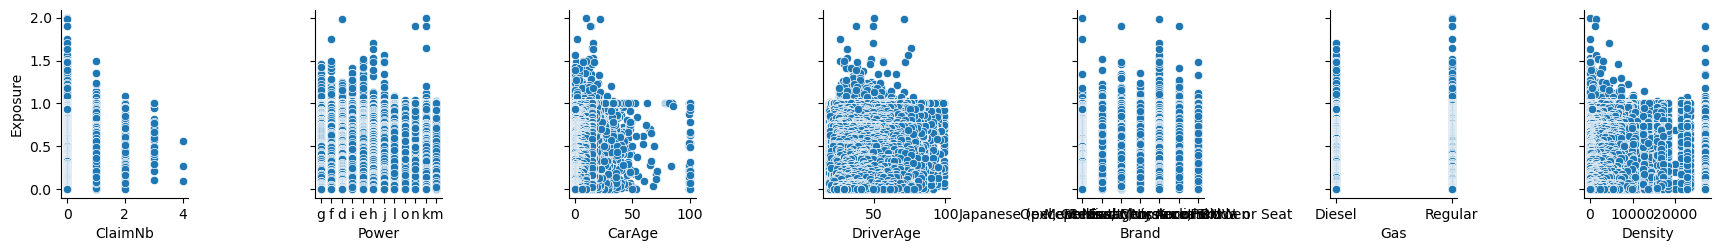

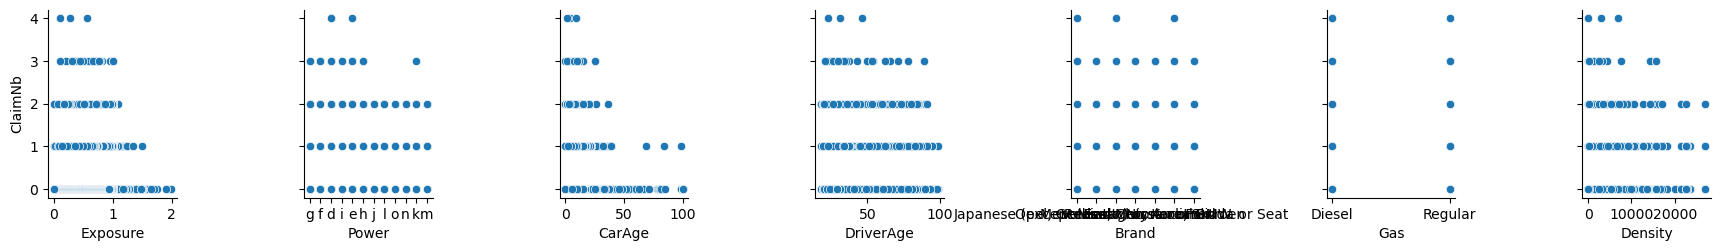

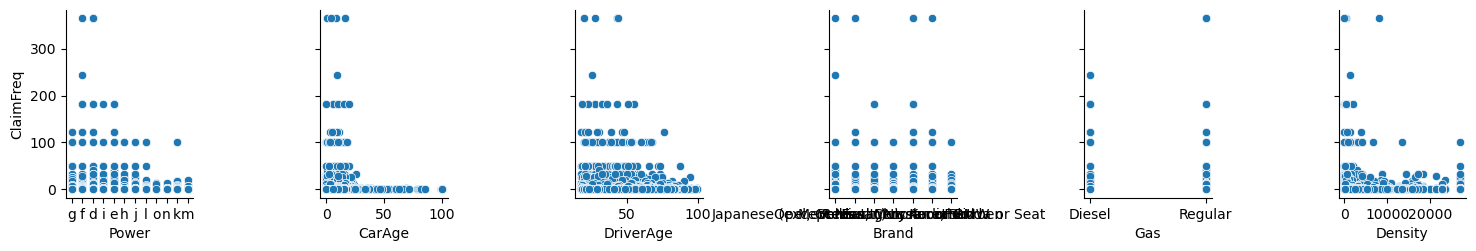

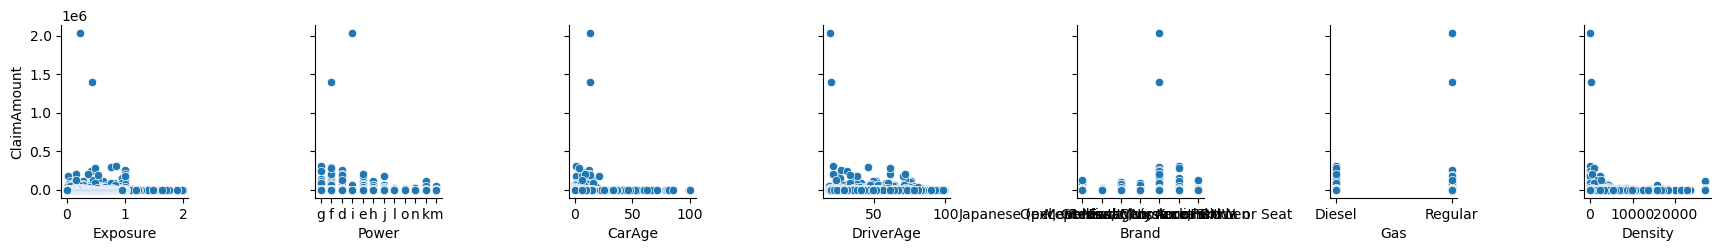

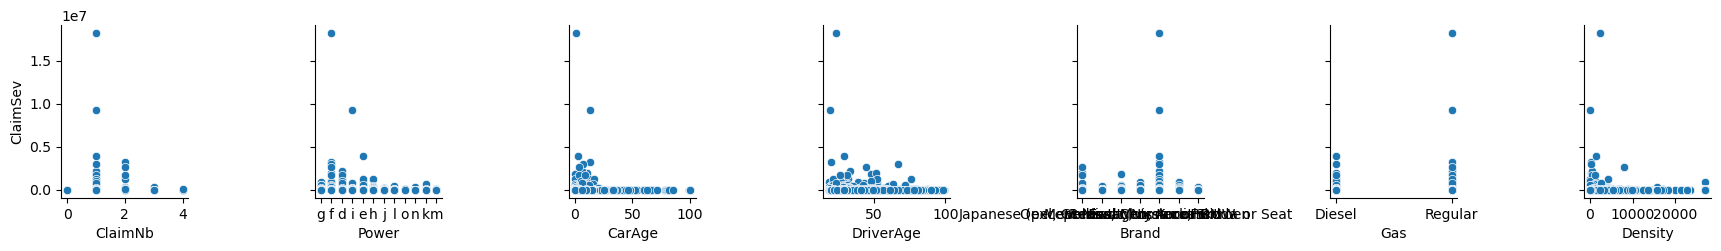

In [11]:
import seaborn as sns
desc_pairplot_x_vars_A = ['ClaimNb', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']
desc_pairplot_x_vars_B = ['Exposure','Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']
desc_pairplot_1 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_A, y_vars='Exposure')
desc_pairplot_1 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimNb')
desc_pairplot_x_vars_C = ['Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']
desc_pairplot_3 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_C, y_vars='ClaimFreq')

# Pairplot 4 - ClaimAmount vs. x_vars.
desc_pairplot_4 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimAmount')

# Pairplot 5 - ClaimSev vs. x_vars (i.e. accounting for policy exposure weighting).
desc_pairplot_5 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_A, y_vars='ClaimSev')

Pairplot 5 shows :

Power: This graph shows that there is an overall negative correlation between the power of the car owned by the policyholder and the exposure-weighted total severity of claims made, however as before there are two major outliers at lower car powers.
CarAge: Similarly to the power of the car, there is an overall negative correlation between the age of the car and the exposure-weighted total severity of claims made by the policyholder, however there are some outliers for relatively new (albeit slightly used) cars.
DriverAge: This graph shows that exposure-weighted claim severities tend to be higher at younger ages (between 20-35), however there is also a smaller group of drivers between 45-55 that are responsible for non-trivial total claim amounts; some major outliers can also be seen for two very new drivers (DriverAge ~ 20).
Brand: Whilst there are a handful of brands that are responsible for higher-than-normal claim severities, these are in the vast minority of policyholders - the overall trend is that there is no clear correlation between the brand of the car and the total claim amount.
Gas: This graph also does not show any clear correlation between ClaimSeverity and the fuel type of the policyholder's car, however there are two distinct outliers within the 'Regular' category.
Density: This graph displays a negative correlation between the total value of claims made by the policyholder and the population density of the city that they liv
e in.

### Step 8: Perform feature selection via L1 regularisation

Next, we will perform feature selection via L1 (lasso) regularisation, in order 
to reduce the number of features that are used for fitting each of the models - 
this is done in order to prevent overfitting. To do this, we add a regularisation 
term (containing the L1 norm) to the standard loss function that is to be minimised, such that:
    
    Loss= Error(y,^y)+λSwi
    
  y is the true value/severity of the claim
  ^y is the claim value/severity predicted by the model 
  λ>0 is the regularisation parameter that determines the strength of regularisation to be applied to the loss function 
  S is the sum 
  wi is the weight of feature i

This modified loss function is then subsequently minimised in order to produce 
the parameters of the Lasso linear regression model. Features that are less 
significant in producing the Lasso model will have their weights/importances 
decreased towards 0 - these "unimportant" features can then be removed from 
the set of inputs/features that are supplied to the models we will use later on.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Establish the Lasso (L1) Regularisation model that will perform feature selection.
lasso = Lasso(alpha=5e-5, random_state=1, max_iter=1e+6).fit(X_train_scale, y_train)
model = SelectFromModel(lasso, prefit=True)

X_train_l1 = model.transform(X_train_scale)

selected_features = pd.DataFrame(model.inverse_transform(X_train_l1),
                                index=X_train_scale.index,
                                columns=X_train_scale.columns)

print(selected_features)
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train_L1reg = selected_features.drop(selected_features.columns[selected_features.var() == 0], axis=1)

print(X_train_L1reg.columns)
print(X_train_L1reg)
# The X_valid dataframe is truncated such that only the L1-selected features are used for validation purposes.
X_valid_L1reg = X_valid_scale[selected_columns]


[330535 rows x 27 columns]
Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Density',
       'prime', 'ClaimFreq', 'Brand_Fiat',
       'Brand_Japanese (except Nissan) or Korean',
       'Brand_Mercedes, Chrysler or BMW', 'Brand_Opel, General Motors or Ford',
       'Brand_Renault, Nissan or Citroen',
       'Brand_Volkswagen, Audi, Skoda or Seat', 'Brand_other', 'Gas_Diesel',
       'Region_Aquitaine', 'Region_Basse-Normandie', 'Region_Bretagne',
       'Region_Centre', 'Region_Haute-Normandie', 'Region_Ile-de-France',
       'Region_Limousin', 'Region_Nord-Pas-de-Calais',
       'Region_Pays-de-la-Loire', 'Region_Poitou-Charentes'],
      dtype='object')
          ClaimNb  Exposure  ...  Region_Pays-de-la-Loire  Region_Poitou-Charentes
PolicyID                     ...                                                  
194119       0.00  0.240163  ...                      1.0                      0.0
293687       0.00  0.501829  ...                      0.0                      0.0
132615       0.25  0.199907  ...                      0.0                      0.0
138539       0.00  0.290483  ...                      0.0                      0.0
217750       0.00  0.260291  ...                      0.0                      0.0
          ...       ...  ...                      ...                      ...
73350        0.00  0.501829  ...                      0.0                      0.0
371404       0.00  0.209971  ...                      0.0                      0.0
312202       0.00  0.189842  ...                      0.0                      0.0
267337       0.00  0.089202  ...                      0.0                      0.0
128038       0.00  0.501829  ...                      0.0                      0.0

30535 rows x 26 columns]



### Step 9: Define the regressors/models used

In this project, we aim to predict the target (ClaimAmount) using the following linear regression approaches
-     Random Forest Regression
They train multiple decision trees on random subsamples of the dataset.
The predictions of each tree are averaged to reduce overlearning and improve robustness.
The principle of Random Forest is quite similar to bagging, except that the drills each time change the very structure of the model.
the exception that the drills change the very structure of the model each time by
 selecting, in addition to the subsample, a subset of the covariates x. We
 We then have a sequence of different trees (drills) trained on different subsamples.
-  samples.

Poisson Regression (GLM)
Generalized Linear Model (GLM) assuming that the target variable follows a Poisson distribution.
Used to model continuous positive claims, but better alternatives exist for this - type of data.

Tweedie Regression
GLM model based on a Tweedie distribution (a mixture of Poisson and Gamma).
Handles claims with a high concentration of zero values (no claims) and a long tail-  for high claims.

XGBoost Regression
Gradient boosting method that improves predictions by successively building decision trees on the residuals of previous predictions.
Highly effective thanks to gradient descent optimisation and widely used in regression problems.



### Step 10: Perform cross-validation to obtain the optimal set of hyperparameters for each model¶

Here, we will perform 5-fold cross-validation in order to optimise one of each models' hyperparameters. These are:

RandomForestRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

n_estimators represents the number of decision trees that are implemented by the random forest regressor. We will aim to optimise this hyperparameter.
random_state sets the random number seed and is used for reproducibility purposes. Here, we set this value to 1.
n_jobs represents the number of calculations to run in parallel; setting a value of -1 means that all processors will be used.
PoissonRegressor

alpha represents the constants that multiplies the penalty term, thus determining the strength of regularisation for the Poisson GLM used. We will aim to optimise this hyperparameter.
max_iter represents the maximal number of iterations for the PoissonRegressor's solver.
TweedieRegressor

power determines the underlying target value's distribution - using a value between 1 and 2 produces a compound Poisson-Gamma distribution.
As a pure Gamma distribution's probability density is not defined at x=0, we set this value to 1.8 such that the target's compound distribution shows more Gamma form than Poisson. This is another hyperparameter that could potentially be optimised for simultaneously, via grid-search methods.

alpha represents the constants that multiplies the penalty term, thus determining the strength of regularisation for the Tweedie GLM used. We will aim to optimise this hyperparameter.
max_iter represents the maximal number of iterations for the TweedieRegressor's solver.
XGBRegressor

n_estimators represents the number of gradient boosted trees implemented by the eXtreme Gradient Boosting (XGB) regressor; this is equivalent to the number of boosting rounds. We will aim to optimise this hyperparameter.
learning_rate refers to the boosting learning rate/step size of the XGB regressor - this value is between 0 and 1.
random_state sets the random number seed and is used for reproducibility purposes. Here, we set this value to 1.


In [ ]:
# Import the regression models from sklearn/xgboost.
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor

# Import the cross_val_score function from sklearn.
from sklearn.model_selection import cross_val_score

## Define scoring functions for each method.

def get_score_RF(n_estimators):
    model_RF = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    
    scores_RF = -1 * cross_val_score(model_RF, X_train_L1reg, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    return scores_RF.mean()

def get_score_PGLM(alpha):
    model_PGLM = PoissonRegressor(alpha=alpha, max_iter=500)
    
    scores_PGLM = -1 * cross_val_score(model_PGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    return scores_PGLM.mean()

def get_score_TGLM(alpha):
    model_TGLM = TweedieRegressor(power=1.8, alpha=alpha, max_iter=500)
    
    scores_TGLM = -1 * cross_val_score(model_TGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    return scores_TGLM.mean()

def get_score_XGB(n_estimators):
    model_XGB = XGBRegressor(n_estimators=n_estimators,
                               learning_rate=0.01,
                               random_state=1)
    
    scores_XGB = -1 * cross_val_score(model_XGB, X_train_L1reg, y_train,
                                     cv=5,
                                     scoring='neg_mean_absolute_error')
    return scores_XGB.mean()


In [ ]:
## Create empty dictionaries which will be used to store the scoring results for each method.
results_RF = {}
results_PGLM = {}
results_TGLM = {}
results_XGB = {}


## Obtain 8 scores for the RandomForestRegressor model.
for i in range(1, 9):
    results_RF[100*i] = get_score_RF(100*i)
    print("results_RF{} recorded".format(i))
print("RF done")


## Obtain 8 scores for the PoissonRegressor model.
for i in range(1, 9):
    results_PGLM[round(0.2*i, 2)] = get_score_PGLM(round(0.2*i, 2))
    print("results_PGLM{} recorded".format(i))
print("PGLM done")


## Obtain 8 scores for the TweedieRegressor model.
for i in range(1, 9):
    results_TGLM[round(0.01*i, 2)] = get_score_TGLM(round(0.01*i, 2))
    print("results_TGLM{} recorded".format(i))

print("TGLM done")

## Obtain 8 scores for the XGBRegressor model.
for i in range(1, 9):
    results_XGB[5*i] = get_score_XGB(5*i)
    print("results_XGB{} recorded".format(i))

print("XGB done")
RF_n_estimators_best = min(results_RF, key=results_RF.get)
print(RF_n_estimators_best)
PGLM_alpha_best = min(results_PGLM, key=results_PGLM.get)
print(PGLM_alpha_best)

TGLM_alpha_best = min(results_TGLM, key=results_TGLM.get)
print(TGLM_alpha_best)
XGB_n_estimators_best = min(results_XGB, key=results_XGB.get)
print(XGB_n_estimators_best)

In [ ]:
results_RF1 recorded
results_RF2 recorded
results_RF3 recorded
results_RF4 recorded
results_RF5 recorded
results_RF6 recorded
results_RF7 recorded
results_RF8 recorded
RF done
results_PGLM1 recorded
results_PGLM2 recorded
results_PGLM3 recorded
results_PGLM4 recorded
results_PGLM5 recorded
results_PGLM6 recorded
results_PGLM7 recorded
results_PGLM8 recorded
PGLM done
results_TGLM1 recorded
results_TGLM2 recorded
results_TGLM3 recorded
results_TGLM4 recorded
results_TGLM5 recorded
results_TGLM6 recorded
results_TGLM7 recorded
results_TGLM8 recorded
TGLM done
results_XGB1 recorded
results_XGB2 recorded
results_XGB3 recorded
results_XGB4 recorded
results_XGB5 recorded
results_XGB6 recorded
results_XGB7 recorded
results_XGB8 recorded
XGB done

700
1.0
0.04
40

### Step 11: Train (fit) the models to the entire training dataset

In [ ]:
# Define the optimised regression models that will be used.

model_RF_opt = RandomForestRegressor(n_estimators=RF_n_estimators_best, random_state=1, n_jobs=-1)

model_PGLM_opt = PoissonRegressor(alpha=PGLM_alpha_best, max_iter=500)

model_TGLM_opt = TweedieRegressor(power=1.8, alpha=TGLM_alpha_best, max_iter=500)

model_XGB_opt = XGBRegressor(n_estimators=XGB_n_estimators_best, learning_rate=0.01, random_state=1)

# Fit the optimised models to the full (pre-processed) training dataset.

model_RF_opt.fit(X_train_L1reg, y_train)
print("model_RF_opt trained")

model_PGLM_opt.fit(X_train_L1reg, y_train)
print("model_PGLM_opt trained")

model_TGLM_opt.fit(X_train_L1reg, y_train)
print("model_TGLM_opt trained")

model_XGB_opt.fit(X_train_L1reg, y_train)
print("model_XGB_opt trained")

model_RF_opt trained
model_PGLM_opt trained
model_TGLM_opt trained
model_XGB_opt trained

### Step 12: Generate a unique set of predictions for each model

The next step is to generate predictions of ClaimAmount for each policyholder 
within the pre-processed validation dataset; this is done using the .predict() 
function for each of the optimised models.

In [ ]:
# Use the trained models to generate unique sets of predicted y-values i.e. ClaimAmount.

preds_RF = model_RF_opt.predict(X_valid_L1reg)
preds_PGLM = model_PGLM_opt.predict(X_valid_L1reg)
preds_TGLM = model_TGLM_opt.predict(X_valid_L1reg)
preds_XGB = model_XGB_opt.predict(X_valid_L1reg)
print("All predictions generated")

All predictions generated
All MAE scores calculated
{'RF': 91.93754684166667, 'PGLM': 118.89131109441652, 'TGLM': 77.9746541216374, 'XGB': 110.0905531806077}
TGLM

### Step 13: Assess the chosen models' performance, using validation data¶

In order to evaluate and rank the models based on their regression performances, 
an appropriate scoring metric should be used. One common example of this is to 
calculate the Mean Absolute Error (MAE) for each of the fitted models against the 
validation data, which can then be ranked in order to determine the model with the 
lowest MAE, which is deemed to be the best model in terms of accuracy and goodness 
of fit:

However, in order to calculate the RMSE of a model, each prediction error must be squared before they are averaged together; this means that larger errors/outliers are more strongly penalised than smaller errors. Therefore, as the vast majority (~96%) of policyholders within the freMTPL dataset have not made any claims whatsoever, we do not wish to heavily penalise each of the models based on any severe claims/outliers that are incorrectly predicted, as this would increase the risk of overfitting each model to these outliers (i.e. by encouraging the model to predict large claims more frequently).
Hence, we will use the mean_absolute_error() function from sklearn.metrics to calculate the MAE score, comparing each model's predictions against the validation dataset's (true) values.


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error metric for each set of predicted y-values.

MAE_RF = mean_absolute_error(y_valid, preds_RF)
MAE_PGLM = mean_absolute_error(y_valid, preds_PGLM)
MAE_TGLM = mean_absolute_error(y_valid, preds_TGLM)
MAE_XGB = mean_absolute_error(y_valid, preds_XGB)
print("All MAE scores calculated")

### Step 14: Evaluate the models' performances

Compare the performance of different regression models for predicting insurance-related data. It uses cross-validation to evaluate each model based on the mean absolute error (MAE) metric.

In [ ]:
# Collect all MAE scores in a single dictionary.
MAE_results = {'RF': MAE_RF,
                'PGLM': MAE_PGLM,
                'TGLM': MAE_TGLM,
                'XGB': MAE_XGB}
print(MAE_results)

# Select the model with the smallest MAE.
best_model = min(MAE_results, key=MAE_results.get)
print(best_model)


print(MAE_results)
{'RF': 91.93754684166667, 'PGLM': 118.89131109441652, 'TGLM': 77.9746541216374, 'XGB': 110.0905531806077}
The best of the 4 models is TweedieRegressor

## Areas for Improvement in the Project
### Approach to Claim Severity Prediction

 - Currently, the project predicts the total loss amount for each policyholder without modeling the average loss per claim.
 - Derive additional features such as the maximum and minimum claim amounts per policyholder to better model severity.
 - The project also uses the actual number of claims from the dataset instead of predicting claim frequency first.
 - Implement the full frequency-severity approach by: Predicting the number of claims using a Poisson regression. Predicting the average claim severity for policyholders with non-zero claims using a Gamma-based GLM.

### Model Training and Testing
Models were trained and tested only once using a basic split (train/test).
Perform multiple training iterations with cross-validation to achieve a more robust fit to the data.

### Data Preprocessing
Categorical encoding methods may not be optimal. For example, one-hot encoding was applied to high-cardinality columns like Region, which is not recommended.
Explore alternatives such as target encoding or embedding layers to handle high-cardinality features more efficiently.

### Hyperparameter Optimization
The current approach involves optimizing one hyperparameter at a time while keeping others constant.
Implement GridSearchCV to perform comprehensive hyperparameter optimization, iterating over a grid of possible values to find the optimal combination.
Example for TweedieRegressor:

### Feature Selection
No strict feature selection was performed, increasing the risk of overfitting.
Use Lasso (L1 regularization) to reduce the number of features by setting higher values for the alpha parameter.
This would require additional hyperparameter tuning to balance feature reduction with model performance.

### For the next steps I am currently working on implementing these improvements. 

Specifically, I am enhancing the frequency-severity approach by predicting both claim frequency and severity.
Applying cross-validation to improve model robustness.
Exploring hyperparameter optimization using GridSearchCV.
Refining data preprocessing and feature selection to reduce model complexity and overfitting.
These changes aim to provide more accurate and generalizable predictions for actuarial pricing models.